In [1]:
!pip install langgraph langsmith transformers




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 18.8 MB/s eta 0:00:00


# Langsmith set-up

In [2]:
import os
from google.colab import userdata

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = userdata.get("LANGSMITH_API_KEY")

In [4]:
import os
from typing import TypedDict, List, Literal
from langsmith import traceable
from langsmith import Client
from langgraph.graph import StateGraph, START, END
from transformers import pipeline

# ---- LangSmith setup ----
client = Client(api_key=os.getenv("LANGSMITH_API_KEY"))

# sample code -- example

In [ ]:
import os
from typing import TypedDict, List, Literal
from langsmith import traceable
from langsmith import Client
from langgraph.graph import StateGraph, START, END
from transformers import pipeline

# ---- LangSmith setup ----
client = Client(api_key=os.getenv("LANGSMITH_API_KEY"))

# ---- State Definition ----
class ReviewState(TypedDict):
    code: str
    readme: str
    context_summary: str
    context_human_comments: str
    llm_review: str
    static_report: str
    peer_comments: List[str]
    approval_status: str  # "approved", "rejected"
    review_round: int
    review_history: List[dict]
    reviewer: str
    submitter: str
    feedback: dict

# ---- Nodes ----

@traceable(run_type="tool", name="Enrich Context (LLM)")
def enrich_context(state: ReviewState):
    print("ENRICH CONTEXT", )
    docs = (state.get("readme") or "") + "\n" + (state.get("code") or "")
    prompt = (
        "Summarize the purpose, inputs, outputs, constraints, and suggest tests for the following code and docs:\n"
        f"{docs}"
    )
    summarizer = pipeline("text-generation", model="mistralai/Mistral-7B-Instruct-v0.2")
    summary = summarizer(prompt, max_length=256)[0]['generated_text']
    state["context_summary"] = summary
    return state

@traceable(run_type="tool", name="Human Context Correction")
def human_context(state: ReviewState):
    print("\n==== LLM Context Summary ====\n", state.get("context_summary", ""))
    correction = input("Add/correct context (or press Enter to accept): ")
    state["context_human_comments"] = correction
    if correction.strip():
        state["context_summary"] += "\nHUMAN: " + correction
    return state

@traceable(run_type="tool", name="Analyze Code (LLM)")
def analyze_code(state: ReviewState):
    print("\n====  Analyzing Code ====\n")
    context = state["context_summary"]
    code = state["code"]
    prompt = (
        f"You are a code reviewer. Given the following context:\n{context}\n"
        f"Review this code:\n{code}\n"
        "Point out bugs, style issues, and suggest improvements:"
    )
    reviewer = pipeline("text-generation", model="mistralai/Mistral-7B-Instruct-v0.2")
    review = reviewer(prompt, max_length=512)[0]['generated_text']
    state["llm_review"] = review
    return state

@traceable(run_type="tool", name="Static Analysis (Optional)")
def static_analysis(state: ReviewState):
    print("\n==== STATIC ANALYSIS ====\n")

    state["static_report"] = "Static analysis: No major issues found (demo)."
    return state

@traceable(run_type="tool", name="Peer Review (Human)")
def peer_review_human(state: ReviewState):
    print("\n==== LLM Review ====\n", state.get("llm_review", ""))
    print("\n==== Static Report ====\n", state.get("static_report", ""))
    comment = input("Reviewer comment (or 'ok' to approve): ")
    if not state.get("peer_comments"):
        state["peer_comments"] = []
    state["peer_comments"].append(comment)
    if comment.strip().lower() == "ok":
        state["approval_status"] = "approved"
    else:
        state["approval_status"] = "rejected"
    return state

@traceable(run_type="tool", name="Comment & Action (LLM+Human)")
def comment_node(state: ReviewState):
    # Optionally generate actionable comments using LLM
    llm = pipeline("text-generation", model="mistralai/Mistral-7B-Instruct-v0.2")
    suggestion = llm(
        "Write actionable comments for the following code review findings:\n"
        + state["llm_review"], max_length=128
    )[0]['generated_text']
    print("\n==== AI-Suggested Comments ====\n", suggestion)
    extra = input("Add/edit comments (or press Enter to accept): ")
    final_comments = suggestion + ("\nHUMAN: " + extra if extra.strip() else "")
    state["peer_comments"].append(final_comments)
    return state

@traceable(run_type="tool", name="Notify Submitter")
def notify_submitter(state: ReviewState):
    # Simulate notifying submitter, in prod send email/slack
    print("\n[To Submitter]: Please see comments and resubmit after fixes.")
    state["review_round"] += 1
    return state

@traceable(run_type="tool", name="Archive Review")
def archive_node(state: ReviewState):
    import json
    with open("review_log.json", "a") as f:
        f.write(json.dumps(state) + "\n")
    print("Review archived.")
    return state

@traceable(run_type="tool", name="Feedback/Retrospective")
def feedback_node(state: ReviewState):
    feedback = input("Any feedback on the review process (optional)? ")
    state["feedback"] = {"submitter": state["submitter"], "feedback": feedback}
    return state

# ---- Conditional Edges ----

def context_needs_human(state) -> Literal["human_context", "analyze"]:
    # If context summary is short/empty, require human fix.
    summary = state.get("context_summary", "")
    if len(summary) < 40:
        return "human_context"
    return "analyze"

def approval_decision(state) -> Literal["archive", "comment_node"]:
    if state["approval_status"] == "approved":
        return "archive"
    else:
        return "comment_node"

def resubmit_or_end(state) -> Literal["enrich", "feedback"]:
    #  limit to 2 review rounds
    if state["review_round"] < 2:
        return "enrich"
    return "feedback"

# ---- Graph Assembly ----

graph = StateGraph(ReviewState)

graph.add_node("enrich", enrich_context)
graph.add_node("human_context", human_context)
graph.add_node("analyze", analyze_code)
graph.add_node("static", static_analysis)
graph.add_node("peer_review", peer_review_human)
graph.add_node("comment_node", comment_node)
graph.add_node("notify", notify_submitter)
graph.add_node("archive", archive_node)
graph.add_node("feedback", feedback_node)

# Start
graph.add_edge(START, "enrich")
graph.add_conditional_edges("enrich", context_needs_human, {"human_context": "human_context", "analyze": "analyze"})
graph.add_edge("human_context", "analyze")
graph.add_edge("analyze", "static")
graph.add_edge("static", "peer_review")
graph.add_conditional_edges("peer_review", approval_decision, {"archive": "archive", "comment_node": "comment_node"})
graph.add_edge("archive", "feedback")
graph.add_edge("comment_node", "notify")
graph.add_conditional_edges("notify", resubmit_or_end, {"enrich": "enrich", "feedback": "feedback"})
graph.add_edge("feedback", END)

peer_review_graph = graph.compile()

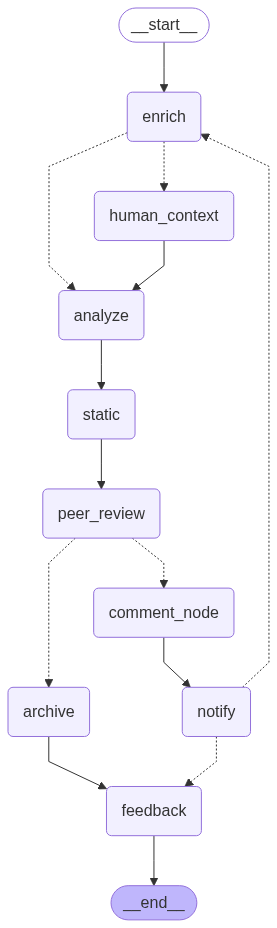

In [ ]:
from IPython.display import Image, display
display(Image(peer_review_graph.get_graph().draw_mermaid_png()))

In [5]:
from huggingface_hub import login
login(new_session=False)

In [ ]:

code =          '''
                  def factorial(n):
                      """Compute the factorial of a number."""
                      if n == 0:
                          return 1
                      else:
                          return n * factorial(n-1)
                 '''
    # Optionally, sample README/docs
readme = """
                  This module contains a recursive function to compute the factorial of a non-negative integer.
                  Handles base case and recursion. Used in math utilities.
    """
submitter = "Alice"
reviewer = "Bob"
state = {
        "code": code,
        "readme": readme,
        "context_summary": "",
        "context_human_comments": "",
        "llm_review": "",
        "static_report": "",
        "peer_comments": [],
        "approval_status": "",
        "review_round": 0,
        "review_history": [],
        "reviewer": reviewer,
        "submitter": submitter,
        "feedback": {},
    }
print("Running the peer review workflow...")
result = peer_review_graph.invoke(state)
print("\n=== Final State ===\n", result)


Running the peer review workflow...
ENRICH CONTEXT


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Device set to use cuda:0


OutOfMemoryError: CUDA out of memory. Tried to allocate 250.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 26.12 MiB is free. Process 8391 has 14.71 GiB memory in use. Of the allocated memory 14.44 GiB is allocated by PyTorch, and 149.35 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [6]:
class ReviewState(TypedDict):
    code: str
    readme: str
    context_summary: str
    context_human_comments: str
    llm_review: str
    static_report: str
    peer_comments: List[str]
    approval_status: str  # "approved", "rejected"
    review_round: int
    review_history: List[dict]
    reviewer: str
    submitter: str
    feedback: dict

#Nodes

In [7]:
@traceable(run_type="tool", name="Enrich Context (LLM)")
def enrich_context(state: ReviewState):
    docs = (state.get("readme") or "") + "\n" + (state.get("code") or "")
    prompt = (
        "Summarize the purpose, inputs, outputs, constraints, and suggest tests for the following code and docs:\n"
        f"{docs}"
    )
    summarizer = pipeline("text-generation", model="mistralai/Mistral-7B-Instruct-v0.2")
    summary = summarizer(prompt, max_length=256)[0]['generated_text']
    state["context_summary"] = summary
    return state

@traceable(run_type="tool", name="Human Context Correction")
def human_context(state: ReviewState):
    print("\n==== LLM Context Summary ====\n", state.get("context_summary", ""))
    correction = input("Add/correct context (or press Enter to accept): ")
    state["context_human_comments"] = correction
    if correction.strip():
        state["context_summary"] += "\nHUMAN: " + correction
    return state

@traceable(run_type="tool", name="Analyze Code (LLM)")
def analyze_code(state: ReviewState):
    context = state["context_summary"]
    code = state["code"]
    prompt = (
        f"You are a code reviewer. Given the following context:\n{context}\n"
        f"Review this code:\n{code}\n"
        "Point out bugs, style issues, and suggest improvements:"
    )
    reviewer = pipeline("text-generation", model="mistralai/Mistral-7B-Instruct-v0.2")
    review = reviewer(prompt, max_length=512)[0]['generated_text']
    state["llm_review"] = review
    return state

@traceable(run_type="tool", name="Static Analysis (Optional)")
def static_analysis(state: ReviewState):
    # Demo: fake static result, in prod run Bandit, Ruff, etc.
    state["static_report"] = "Static analysis: No major issues found (demo)."
    return state

@traceable(run_type="tool", name="Peer Review (Human)")
def peer_review_human(state: ReviewState):
    print("\n==== LLM Review ====\n", state.get("llm_review", ""))
    print("\n==== Static Report ====\n", state.get("static_report", ""))
    comment = input("Reviewer comment (or 'ok' to approve): ")
    if not state.get("peer_comments"):
        state["peer_comments"] = []
    state["peer_comments"].append(comment)
    if comment.strip().lower() == "ok":
        state["approval_status"] = "approved"
    else:
        state["approval_status"] = "rejected"
    return state

@traceable(run_type="tool", name="Comment & Action (LLM+Human)")
def comment_node(state: ReviewState):
    # Optionally generate actionable comments using LLM
    llm = pipeline("text-generation", model="mistralai/Mistral-7B-Instruct-v0.2")
    suggestion = llm(
        "Write actionable comments for the following code review findings:\n"
        + state["llm_review"], max_length=128
    )[0]['generated_text']
    print("\n==== AI-Suggested Comments ====\n", suggestion)
    extra = input("Add/edit comments (or press Enter to accept): ")
    final_comments = suggestion + ("\nHUMAN: " + extra if extra.strip() else "")
    state["peer_comments"].append(final_comments)
    return state

@traceable(run_type="tool", name="Notify Submitter")
def notify_submitter(state: ReviewState):
    # Simulate notifying submitter, in prod send email/slack
    print("\n[To Submitter]: Please see comments and resubmit after fixes.")
    state["review_round"] += 1
    return state

@traceable(run_type="tool", name="Archive Review")
def archive_node(state: ReviewState):
    import json
    with open("review_log.json", "a") as f:
        f.write(json.dumps(state) + "\n")
    print("Review archived.")
    return state

@traceable(run_type="tool", name="Feedback/Retrospective")
def feedback_node(state: ReviewState):
    feedback = input("Any feedback on the review process (optional)? ")
    state["feedback"] = {"submitter": state["submitter"], "feedback": feedback}
    return state

# ---- Conditional Edges ----

def context_needs_human(state) -> Literal["human_context", "analyze"]:
    # If context summary is short/empty, require human fix.
    summary = state.get("context_summary", "")
    if len(summary) < 40:
        return "human_context"
    return "analyze"

def approval_decision(state) -> Literal["archive", "comment_node"]:
    if state["approval_status"] == "approved":
        return "archive"
    else:
        return "comment_node"

def resubmit_or_end(state) -> Literal["enrich", "feedback"]:
    # Demo: limit to 2 review rounds
    if state["review_round"] < 2:
        return "enrich"
    return "feedback"

#Architecture

In [8]:
graph = StateGraph(ReviewState)

graph.add_node("enrich", enrich_context)
graph.add_node("human_context", human_context)
graph.add_node("analyze", analyze_code)
graph.add_node("static", static_analysis)
graph.add_node("peer_review", peer_review_human)
graph.add_node("comment_node", comment_node)
graph.add_node("notify", notify_submitter)
graph.add_node("archive", archive_node)
graph.add_node("feedback", feedback_node)

# Start
graph.add_edge(START, "enrich")
graph.add_conditional_edges("enrich", context_needs_human, {"human_context": "human_context", "analyze": "analyze"})
graph.add_edge("human_context", "analyze")
graph.add_edge("analyze", "static")
graph.add_edge("static", "peer_review")
graph.add_conditional_edges("peer_review", approval_decision, {"archive": "archive", "comment_node": "comment_node"})
graph.add_edge("archive", "feedback")
graph.add_edge("comment_node", "notify")
graph.add_conditional_edges("notify", resubmit_or_end, {"enrich": "enrich", "feedback": "feedback"})
graph.add_edge("feedback", END)

# compile

In [9]:
peer_review_graph = graph.compile()

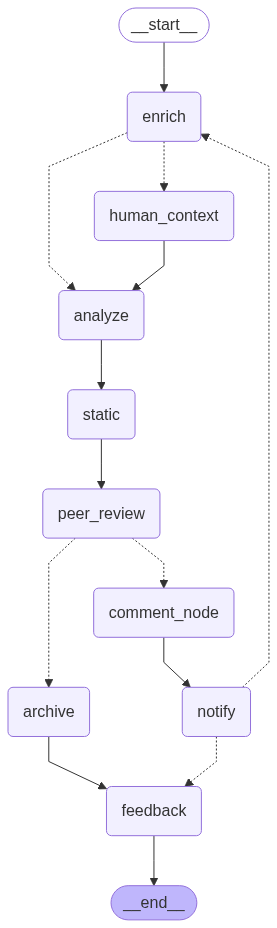

In [10]:
from IPython.display import Image, display
display(Image(peer_review_graph.get_graph().draw_mermaid_png()))

In [11]:

code =          '''
                  def factorial(n):
                      """Compute the factorial of a number."""
                      if n == 0:
                          return 1
                      else:
                          return n * factorial(n-1)
                 '''
    # Optionally, sample README/docs
readme = """
                  This module contains a recursive function to compute the factorial of a non-negative integer.
                  Handles base case and recursion. Used in math utilities.
    """
submitter = "Alice"
reviewer = "Bob"
state = {
        "code": code,
        "readme": readme,
        "context_summary": "",
        "context_human_comments": "",
        "llm_review": "",
        "static_report": "",
        "peer_comments": [],
        "approval_status": "",
        "review_round": 0,
        "review_history": [],
        "reviewer": reviewer,
        "submitter": submitter,
        "feedback": {},
    }
print("Running the peer review workflow...")
result = peer_review_graph.invoke(state)
print("\n=== Final State ===\n", result)


Running the peer review workflow...


config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.10k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

Device set to use cuda:0
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=256) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Device set to use cuda:0
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=512) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



==== LLM Review ====
 You are a code reviewer. Given the following context:
Summarize the purpose, inputs, outputs, constraints, and suggest tests for the following code and docs:

                  This module contains a recursive function to compute the factorial of a non-negative integer.
                  Handles base case and recursion. Used in math utilities.
    

                  def factorial(n):
                      """Compute the factorial of a number."""
                      if n == 0:
                          return 1
                      else:
                          return n * factorial(n-1)
                  """Output: A single integer representing the factorial of the input."""

Purpose: The purpose of this code is to define a recursive function named "factorial" that computes the factorial of a given non-negative integer input.

Inputs: The function accepts one input "n" which is a non-negative integer.

Outputs: The function returns a single integer as the ou